# Исследование данных о всемирных продажах компьютерных игр

Данная работа посвящена исследованию исторических данных о продажах игр, полученных из открытых источников. Необходимо выявить закономерности, определяющие успешность игры. Это позволит определить потенциально популярный продукт и спланировать рекламные кампании некоего условного интернет-магазина.

Полученные данные покрывают временной период вплоть до 2016 г. Представим, что сейчас декабрь 2016 г., и мы планируем кампанию на 2017-й. При этом данные за 2016 год могут быть неполными.

[Страница датасета на Kaggle](https://www.kaggle.com/datasets/gregorut/videogamesales)

Описание данных:
- **Name** — название игры
- **Platform** — платформа
- **Year_of_Release** — год выпуска
- **Genre** — жанр игры
- **NA_sales** — продажи в Северной Америке (миллионы проданных копий)
- **EU_sales** — продажи в Европе (миллионы проданных копий)
- **JP_sales** — продажи в Японии (миллионы проданных копий)
- **Other_sales** — продажи в других странах (миллионы проданных копий)
- **Critic_Score** — оценка критиков (максимум 100)
- **User_Score** — оценка пользователей (максимум 10)
- **Rating** — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

Предполагаемый план работы:
1. Открытие данных и корректное их чтение
2. Подготовка данных
3. Исследовательский анализ данных
4. Составление портрета пользователя каждого региона
5. Проверка гипотез, связанных со средними пользовательскими рейтингами
6. Формирование общего вывода

### Открытие данных и корректное их чтение

Импортируем библиотеки и подгрузим данные в датафрейм:

In [206]:
import os
import pandas as pd
from scipy import stats as st
import matplotlib.pyplot as plt 
%matplotlib inline

In [207]:
pth1 = '/datasets/games.csv'

if os.path.exists(pth1):
    data = pd.read_csv(pth1)
else:
    print('Error in importing data')

In [208]:
data.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Данные считаны корректно, изучим их общую информацию

In [209]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [210]:
data.describe()

,Year_of_Release,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score
count,16446.000000,16715.000000,16715.000000,16715.000000,16715.000000,8137.000000
mean,2006.484616,0.263377,0.145060,0.077617,0.047342,68.967679
std,5.877050,0.813604,0.503339,0.308853,0.186731,13.938165
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000


В сумме 11 признаков, из них 4 категориальных, 6 количественных и 1 отображает дату
При этом данные содержат записи с 1980 по 2016 год, а средняя оценка критиков - примерно 70 баллов.

Как можно заметить, большое количество пропусков сосредоточено в столбцах `Critic_Score, User_Score и Rating`

Для `Critic_Score` процент пропусков наибольший - 51%. Данную проблему необходимо будет решить на этапе предобработки данных. Может быть, эти данные относятся только к устаревшим наблюдениям, которые и так необходимо отбросить для формирования актуального периода.

Для более глубокого понимания количественных признаков взглянем на их гистограммы распределений:

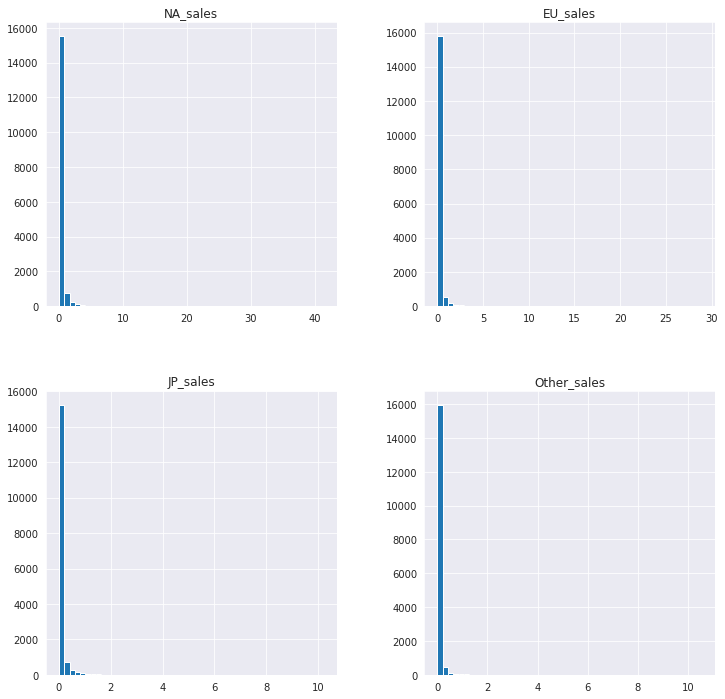

In [211]:
data.loc[:, "NA_sales":"Other_sales"].hist(bins=50, figsize=(12, 12));

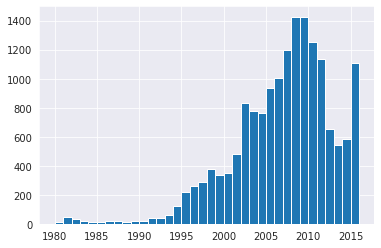

In [212]:
data['Year_of_Release'].hist(bins=36);

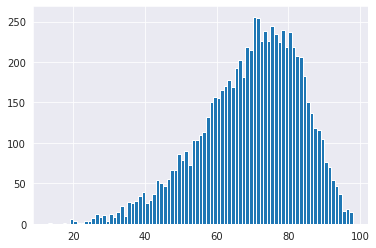

In [213]:
data['Critic_Score'].hist(bins=85);

Из полученных графиков можно сделать следующие выводы:
1. Признаки типа `*_sales` скорее всего содержат выбросы. Это может быть связано с некими играми с сильным коммерческим успехом. На этапе предобработки стоит оценить количество таких игр и проверить правдивость данных.
2. `Year_Of_Release` совпадает с ожидаемым видом распределения и при этом большинство наблюдений сосредоточены в промежутке между 2000 и 2010 годами. Однако, не совсем понятно, чем обусловлен спад создания видеоигр после 2010 года. Скорее всего, неполнотой данных.
3. `Critic_Score` тоже совпадает с ожидаемым видом, и при этом большинство игр оценивается выше среднего. Это промежуток от 60 до 80 баллов, что так же совпадает с характеристиками расположения данных, полученных ранее.

### Подготовка данных

#### Изменение стиля оформления столбцов

Для начала приведем названия столбцов к корректному виду
Еще раз выведем названия всех столбцов:

In [214]:
data.columns

Index(['Name', 'Platform', 'Year_of_Release', 'Genre', 'NA_sales', 'EU_sales',
       'JP_sales', 'Other_sales', 'Critic_Score', 'User_Score', 'Rating'],
      dtype='object')

In [215]:
data.columns = data.columns.str.lower()

In [216]:
data = data.rename(columns={
    "year_of_release" : "year"
})

In [217]:
data.columns

Index(['name', 'platform', 'year', 'genre', 'na_sales', 'eu_sales', 'jp_sales',
       'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

Здесь мы привели все названия к snake_case и сократили `Year_of_Release` до `year` для упрощения.


#### Изменение типов данных

Приведем признак `year` к целочисленному, т.к. там содержится только год.
А признак `user_score` приведем к типу с плавающей точкой, аналогично `critical_score`

In [218]:
data["year"] = data["year"].astype("Int64")
data["user_score"] = pd.to_numeric(data["user_score"], errors='coerce')

In [219]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   name          16713 non-null  object 
 1   platform      16715 non-null  object 
 2   year          16446 non-null  Int64  
 3   genre         16713 non-null  object 
 4   na_sales      16715 non-null  float64
 5   eu_sales      16715 non-null  float64
 6   jp_sales      16715 non-null  float64
 7   other_sales   16715 non-null  float64
 8   critic_score  8137 non-null   float64
 9   user_score    7590 non-null   float64
 10  rating        9949 non-null   object 
dtypes: Int64(1), float64(6), object(4)
memory usage: 1.4+ MB


#### Удаление пропусков

Посмотрим на количество пропусков для каждого признака:

In [220]:
data.isna().sum().sort_values(ascending=False)

user_score      9125
critic_score    8578
rating          6766
year             269
name               2
genre              2
platform           0
na_sales           0
eu_sales           0
jp_sales           0
other_sales        0
dtype: int64

И в процентах:

In [221]:
data.isna().sum().sort_values(ascending=False) / data.shape[0] * 100

user_score      54.591684
critic_score    51.319174
rating          40.478612
year             1.609333
name             0.011965
genre            0.011965
platform         0.000000
na_sales         0.000000
eu_sales         0.000000
jp_sales         0.000000
other_sales      0.000000
dtype: float64

Пропуски в признаке `year` составляют менее 2% от всех наблюдений, поэтому их (вместе с пропусками в `name` и `genre`) можно отбросить

In [222]:
data = data.dropna(subset=["year", "name", "genre"])

Изучим пропуски в `critic_score` для поиска возможной закономерности

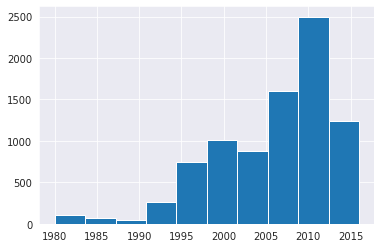

In [223]:
data.loc[data['critic_score'].isna()]['year'].hist();

In [224]:
data.loc[data['critic_score'].notna()].describe()

,year,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score
count,7983.000000,7983.000000,7983.000000,7983.000000,7983.000000,7983.000000,6894.000000
mean,2007.192785,0.354536,0.209798,0.055910,0.072935,68.994363,7.184378
std,4.189425,0.902590,0.640720,0.267412,0.251262,13.920060,1.439806
min,1985.000000,0.000000,0.000000,0.000000,0.000000,13.000000,0.500000
25%,2004.000000,0.050000,0.010000,0.000000,0.010000,60.000000,6.500000
50%,2007.000000,0.130000,0.050000,0.000000,0.020000,71.000000,7.500000
75%,2010.000000,0.340000,0.180000,0.010000,0.060000,79.000000,8.200000
max,2016.000000,41.360000,28.960000,6.500000,10.570000,98.000000,9.600000


In [225]:
data.loc[data['critic_score'].isna()].describe()

,year,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score
count,8461.000000,8461.000000,8461.000000,8461.000000,8461.000000,0.0,569.000000
mean,2005.819643,0.178603,0.085671,0.099788,0.023684,NaN,6.423023
std,7.044294,0.719761,0.322860,0.345986,0.089195,NaN,1.960422
min,1980.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000
25%,2001.000000,0.000000,0.000000,0.000000,0.000000,NaN,5.300000
50%,2008.000000,0.020000,0.000000,0.000000,0.000000,NaN,7.000000
75%,2011.000000,0.140000,0.050000,0.070000,0.020000,NaN,7.900000
max,2016.000000,29.080000,10.950000,10.220000,2.740000,NaN,9.700000


In [226]:
data.loc[data['critic_score'].notna()]['platform'].value_counts()

PS2     1275
X360     894
PS3      804
DS       708
XB       706
PC       699
Wii      568
PSP      456
GC       437
GBA      430
PS4      252
PS       196
XOne     169
3DS      166
PSV      119
WiiU      90
DC        14
Name: platform, dtype: int64

In [227]:
data[data['critic_score'].isna()]['platform'].value_counts()

DS      1413
PS       994
PS2      852
PSP      737
Wii      718
PS3      502
GBA      381
3DS      346
X360     338
N64      316
PSV      310
PC       258
SNES     239
SAT      173
PS4      140
2600     116
GC       105
NES       98
GB        97
XB        97
XOne      78
WiiU      57
DC        38
GEN       27
NG        12
SCD        6
WS         6
3DO        3
TG16       2
GG         1
PCFX       1
Name: platform, dtype: int64

In [228]:
data.loc[data['critic_score'].notna()]['genre'].value_counts()

Action          1851
Sports          1165
Shooter          923
Role-Playing     731
Racing           725
Misc             509
Platform         490
Fighting         405
Simulation       348
Adventure        320
Strategy         296
Puzzle           220
Name: genre, dtype: int64

In [229]:
data[data['critic_score'].isna()]['genre'].value_counts()

Action          1456
Misc            1212
Sports          1141
Adventure        973
Role-Playing     750
Simulation       509
Racing           501
Fighting         432
Platform         388
Strategy         377
Shooter          373
Puzzle           349
Name: genre, dtype: int64

Данные с пропусками мало отличаются от данных без. Большинство из них присутствуют после 2010 года, продажи у игр с пропусками даже больше среднего в некоторых регионах, а жанры в большинстве совпадают. В данных с пропусками самой популярной платформой является DS, а без пропусков - PS2. Однако, остальные популярные платформы примерно одинаковые.

При необходимости, можно было бы попробовать получить недостающие данные из других датасетов, которые есть в открытых источниках. Однако, в данных условиях это трудно реализуемо технически.

Так же исследование больше сконцентрировано на аспекте продаж видеоигр, а не их хороших оценках. При этом данные о продажах у нас имеются без пропусков.

В связи с этим, данные пропуски в столбцах `user_score, critic_score и rating` можно оставить. В будущем необходимо учесть, что при работе с этими столбцами, наблюдений будет примерно в половину меньше, чем в других случаях.

Скорее всего, пропуски в данных появились во время формирования данных. Возможно, они были взяты из разных источников.

#### Подсчет общего числа продаж по всем регионам

In [230]:
data['total_sales'] = data.loc[:, "na_sales":"other_sales"].sum(axis=1)

#### Удаление выбросов (аномалий)

In [231]:
data.loc[:, "na_sales":"other_sales"].describe()

,na_sales,eu_sales,jp_sales,other_sales
count,16444.000000,16444.000000,16444.000000,16444.000000
mean,0.264012,0.145930,0.078487,0.047594
std,0.818378,0.506716,0.311100,0.188005
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.080000,0.020000,0.000000,0.010000
75%,0.240000,0.110000,0.040000,0.030000
max,41.360000,28.960000,10.220000,10.570000


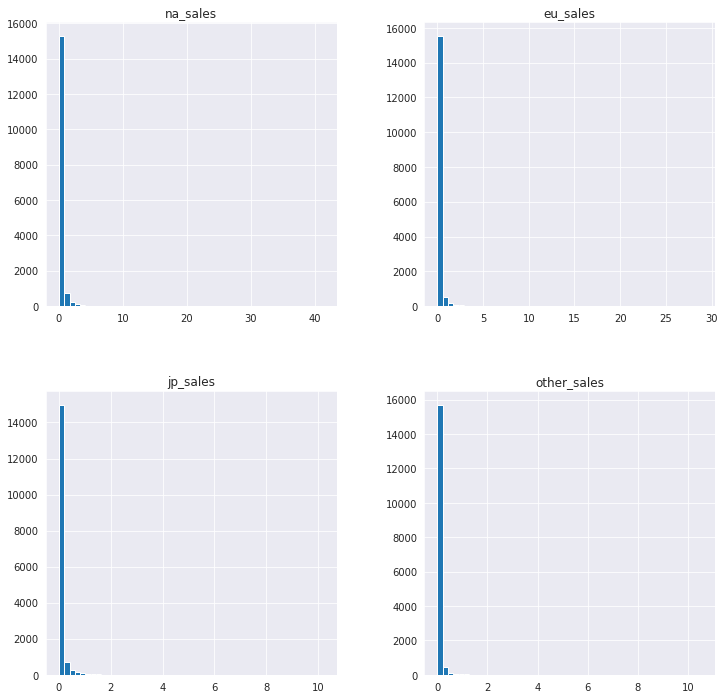

In [232]:
data.loc[:, "na_sales":"other_sales"].hist(bins=50, figsize=(12, 12));

Для каждого признака количества продаж необходимо отсечь аномально высокие значения

Для выбора верхней границы этих значений изучим их гистограммы распределений и посчитаем, сколько процентов выбросы составляют от всех данных.

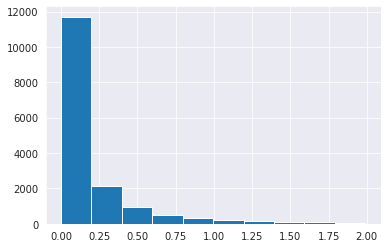

In [233]:
data[data["na_sales"] < 2]["na_sales"].hist();

In [234]:
data.query("na_sales > 2")['na_sales'].count() / data.shape[0] * 100

1.933836049622963

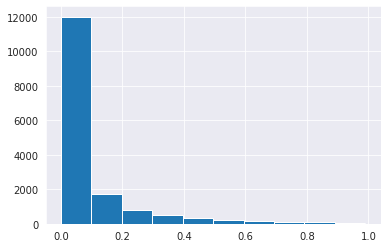

In [235]:
data[data["eu_sales"] < 1]["eu_sales"].hist();

In [236]:
data.query("eu_sales > 1")['eu_sales'].count() / data.shape[0] * 100

2.8460228654828508

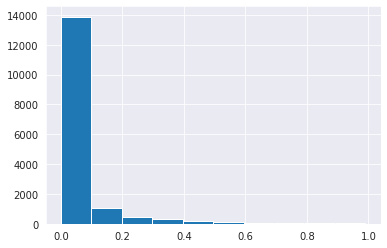

In [237]:
data[data["jp_sales"] < 1]["jp_sales"].hist()
None

In [238]:
data.query("jp_sales > 1")['jp_sales'].count() / data.shape[0] * 100

1.453417659936755

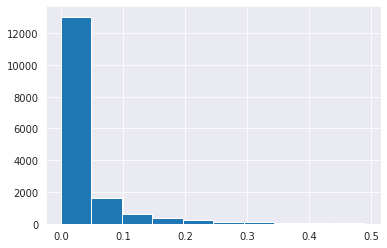

In [239]:
data[data["other_sales"] < 0.5]["other_sales"].hist();

In [240]:
data.query("other_sales > 0.5")['other_sales'].count() / data.shape[0] * 100

1.3865239601070298

В сумме выбросы составляю 4.6% от общего объема данных и представляют игры с сильным коммерческим успехом. В связи с этим, их не стоит отбрасывать для сохранения реальной картины событий в продажах.


Поиск явных дубликатов:

In [241]:
data[data.duplicated(subset=['name', 'platform'], keep=False)]

,name,platform,year,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
604,Madden NFL 13,PS3,2012,Sports,2.11,0.22,0.00,0.23,83.0,5.5,E,2.56
1190,Need for Speed: Most Wanted,X360,2012,Racing,0.62,0.78,0.01,0.15,83.0,8.5,T,1.56
1591,Need for Speed: Most Wanted,X360,2005,Racing,1.00,0.13,0.02,0.10,83.0,8.5,T,1.25
5972,Need for Speed: Most Wanted,PC,2005,Racing,0.02,0.23,0.00,0.04,82.0,8.5,T,0.29
11715,Need for Speed: Most Wanted,PC,2012,Racing,0.00,0.06,0.00,0.02,82.0,8.5,T,0.08
16230,Madden NFL 13,PS3,2012,Sports,0.00,0.01,0.00,0.00,83.0,5.5,E,0.01


Поиск неявных дубликатов в названиях платформ:

In [242]:
data['platform'].unique()

array(['Wii', 'NES', 'GB', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'GBA',
       'PS4', '3DS', 'N64', 'PS', 'XB', 'PC', '2600', 'PSP', 'XOne',
       'WiiU', 'GC', 'GEN', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG', 'TG16',
       '3DO', 'GG', 'PCFX'], dtype=object)

В результате поиска дубликатов, не было найдено неявных дубликатов среди платформ. Были найдены 3 игры, название и платформа которых встречались два раза. Однако, в случае Need for Speed: Most Wanted дубликаты валидны, т.к. описывают две разные игры - 2012 и 2005 года. Однако, для игры Madden NFL 13 запись все же повторяется. Из открытых источников есть данные, что за первую неделю своего выпуска данная игра продала 1.65 млн копий.(https://www.ign.com/articles/2012/09/06/madden-nfl-13-sales-pass-16-million) Поэтому, запись об игре в 604 строке можно оставить, а в 16230 - удалить

In [243]:
data = data.drop(16230)

In [244]:
data[data.duplicated(subset=['name', 'platform', 'year'], keep=False)]

,name,platform,year,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales


Во время выполнения предобработки данных были удалены явные дубликаты, были изменены типы столбцов и их названия на более корректные.

Так же для некоторых признаков были построены гистограммы распределений. Данные с экстремальными значениями было решено оставить для корректного дальнейшего исследования.

Данные готовы к работе и можно приступить к исследовательскому анализу данных

### Исследовательский анализ данных

Рассмотрим, сколько игр выпускалось в разные годы

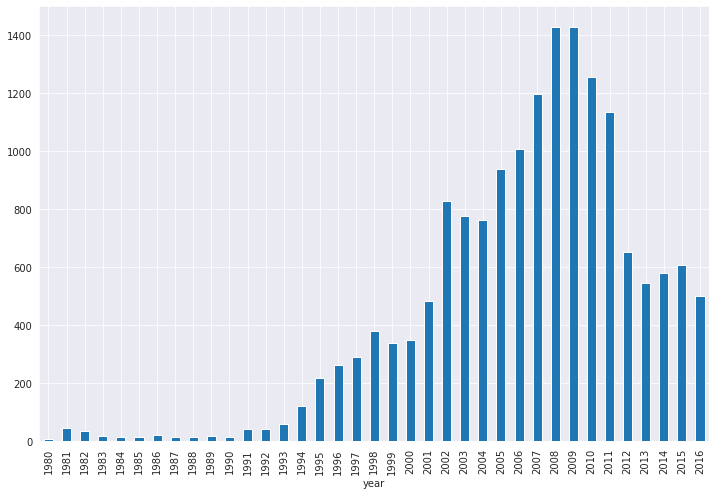

In [245]:
data.groupby('year')['name'].count().plot(kind="bar", figsize=(12, 8));

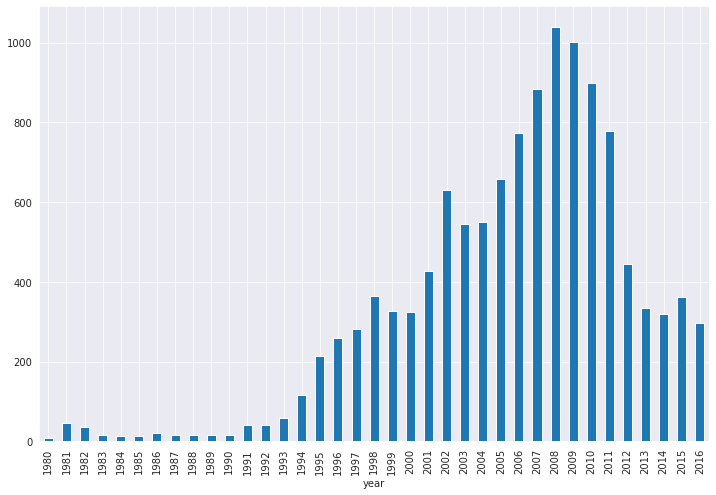

In [246]:
data.groupby('year')['name'].nunique().plot(kind="bar", figsize=(12, 8));

По графику видно, что больше всего игр в данные появились с 2002 по 2012 год. Пик выпуска игр в 2008 году скорее всего связан с повышением доступности персонального компьютера, появлением новых игровых платформ и хороших продаж в предыдущих годах, что повлияло на потенциальную заинтересованность инвесторов в сфере разработки игр. До 2000 годов продажа игр была меньше всего.

В целом, можно сказать, что данные об играх, выпущенных раньше 2000 года можно отбросить из-за их относительно малого количества и релевантности.

Но перед этим так же стоит посмотреть, как менялись продажи по самым популярным платформам, для которых выпускались игры:

In [247]:
top_10_platforms = data['platform'].value_counts().index[:10]

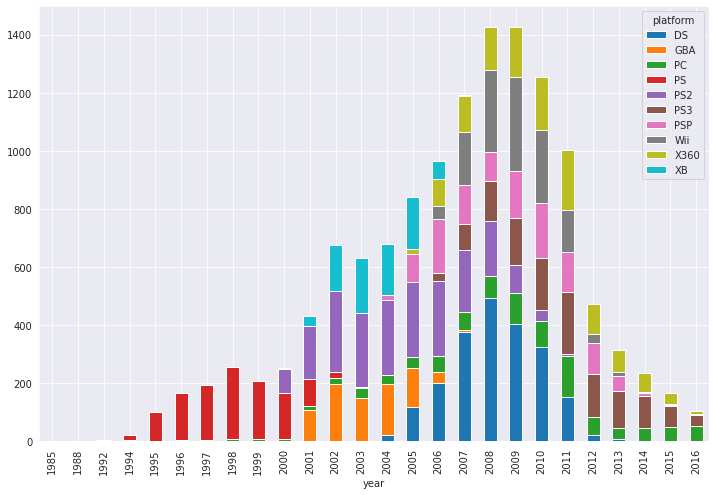

In [248]:
(
data
    .query("platform in @top_10_platforms")
    .pivot_table(index="year", columns="platform", values="total_sales", aggfunc="count")
    .plot(kind="bar",stacked=True, figsize=(12, 8))
);

По полученному графику можно сделать следующие выводы:
1. Есть некая закономерность в разных версиях одной платформы. Хорошим примером являются PS, PS2 и PS3. Так, при появлении PS2 популярность PS1 каждый год падает почти на столько же, на сколько она растет у PS2.
2. Платформа персонального компьютера (PC) показывает относительно малые значения, но существует дольше всех остальных платформ. Скорее всего, так и останется в будущем, что связано с самим устройством данной платформы.
3. В среднем одна платформа релевантна на рынке в течении 8 - 10 лет.
4. Максимум игр для конкретной платформы выпускается примерно через 3 года после ее появления.
5. Есть популярные семейства консолей, которые существуют долгое время (Xbox, PS).

Исследовав предыдущие графики, можно определить соответствующий **актуальный период**.

Для того чтобы лучше отразить текущее состояние сферы, за этот период можно взять данные с 2014 года как самый релевантный текущей ситуации на рынке.

Формирование актуального периода:

In [249]:
data = data.query("year > 2013")

Также проанализируем платформы для актуального периода:

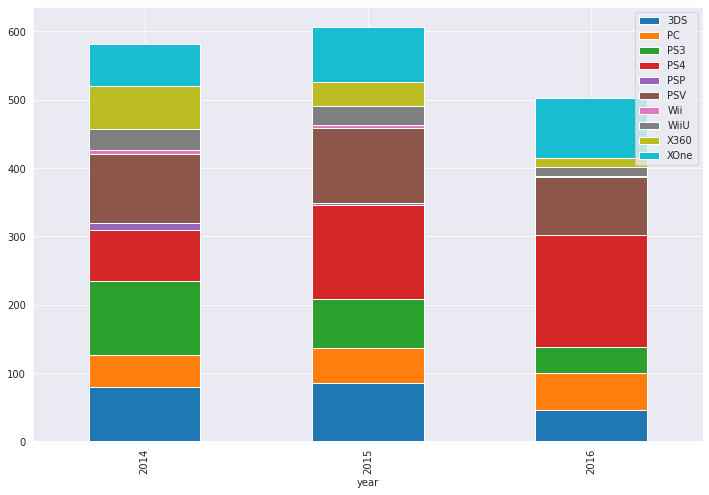

In [250]:
(
    data
    .pivot_table(index="year", columns="platform", values="total_sales", aggfunc="count")
    .plot(kind="bar",stacked=True, figsize=(12, 8))
)

plt.legend(loc='upper right');

По графику заметно следующее:

1. Платформы, набирающие популярность:
* PS4
* XOne
* PC

2. Платформы, теряющие популярность:
* 3DS
* PS3
* PSP
* PSV
* Wii
* WiiU
* X360

3. Потенциально прибыльные платформы:
* XOne
* PS4
* PC

Рассмотрим глобальные продажи по платформам:

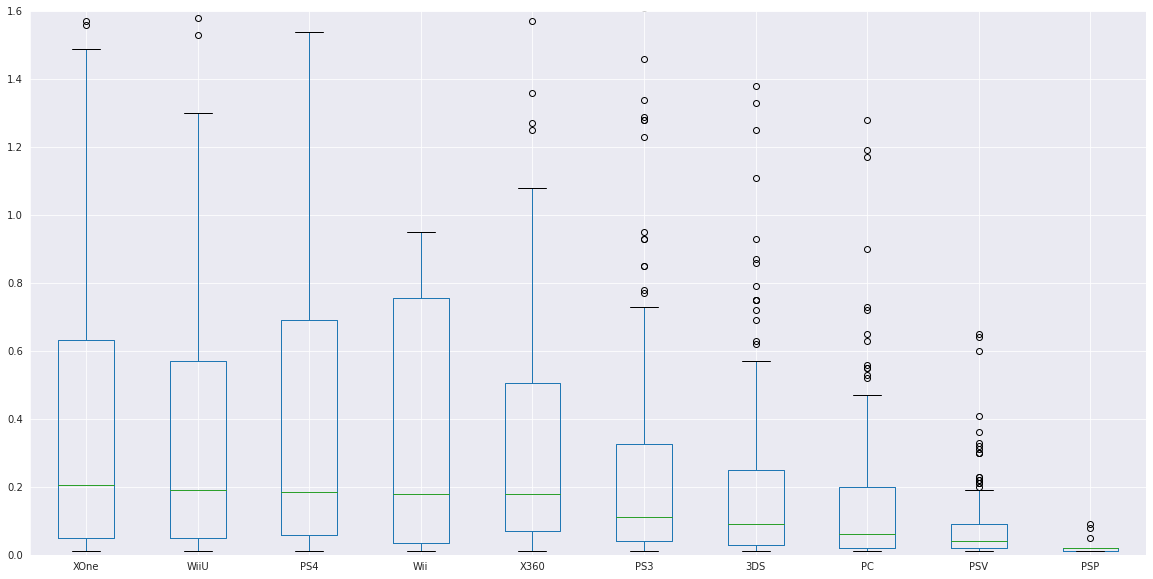

In [251]:
#группировка данных по платформе и создание датасета с их общим числом продаж
grouped = data.groupby("platform")
data2 = pd.DataFrame({col:vals['total_sales'] for col,vals in grouped})

#вычисление медиан для последующей сортировки
medians = data2.median()
medians.sort_values(ascending=False, inplace=True)

#перестановка столбцов
data2 = data2[medians.index]

#построение графиков
ax = data2.boxplot(figsize=(20, 10))
ax.set_ylim(0, 1.6)
None

Как можно заметить, у платформ, которые вышли недавно(XOne, PS4) гораздо больше продаж, чем у их предшественников (X360 и PS3). Это еще раз подтверждает актуальность этих двух платформ в текущее время, а под платформы XOne и PS4 можно надежно закупать игры.

Платформы 3DS, PSV и PSP имеют крайне мало продаж и теряют свою популярность, поэтому игры для них закупать не стоит.

Платформа PC имеет малое среднее число продаж, но достаточно большой размах аномальных значений. Учитывая, что эта платформа существует дольше всех, скорее всего, есть смысл вкладывать в нее средства.

Возьмем PS3 как самую популярную платформу и посмотрим, как отзывы влияют на её продажи игр:

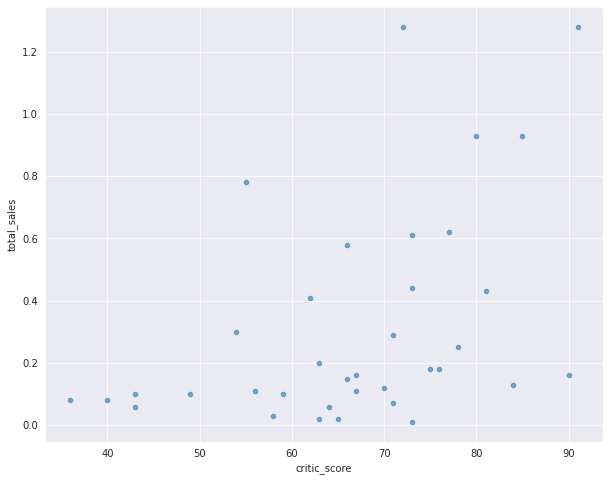

In [252]:
data[data['platform'] == "PS3"].plot(kind="scatter", x="critic_score", y="total_sales", alpha=0.6, figsize=(10, 8))
None

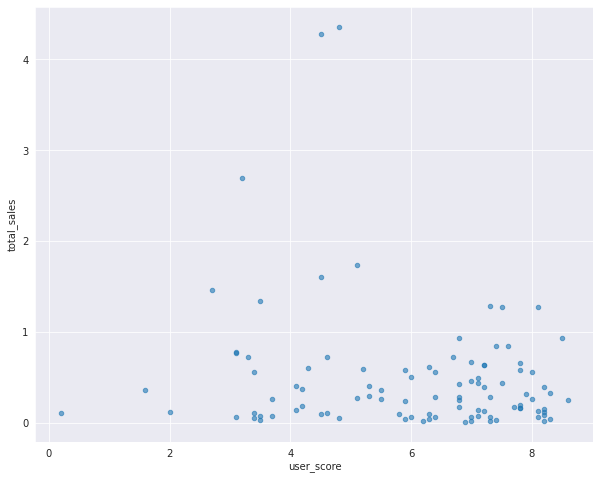

In [253]:
data[data['platform'] == "PS3"].plot(kind="scatter", x="user_score", y="total_sales", alpha=0.6, figsize=(10, 8))
None

<AxesSubplot:>

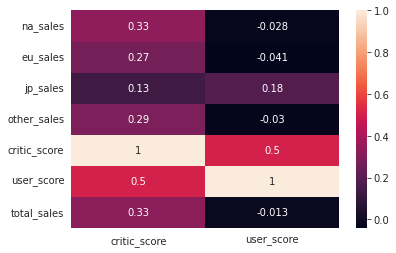

In [254]:
import seaborn as sns
sns.heatmap(data.corr().loc["na_sales":, ["critic_score", "user_score"]], annot=True)

Как можно заметить, есть некая связь между высокой оценкой и большим количеством продаж. При этом для оценок критиков, она присутствует более явно, чем для оценок пользователей.

В результате исследования взаимосвязи отзывов и продаж игры было установлено, что между количеством продаж игры и её оценками критиками существует средне-слабая корреляция. При этом оценки пользователей корреляцию с продажами не демонстрируют.

Далее, взглянем на популярность конкретных жанров.

Процент конкретного жанра от всех игр:

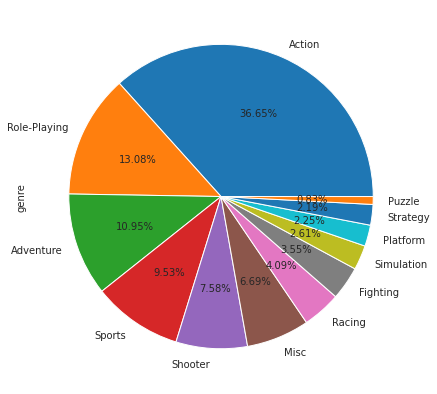

In [255]:
data['genre'].value_counts().plot(kind="pie", autopct='%1.2f%%', figsize=(7, 7))
None

Суммарные продажи конкретного жанра за актуальный период:

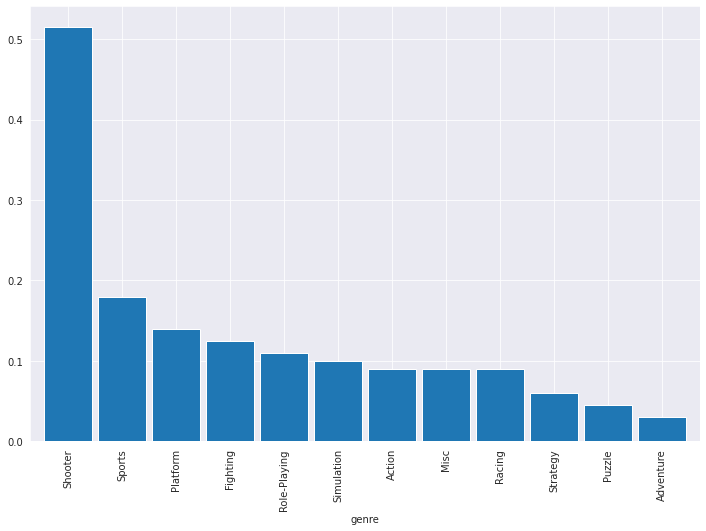

In [256]:
data.groupby("genre")["total_sales"].agg("median")\
    .sort_values(ascending=False).plot(kind="bar", width=0.9, figsize=(12, 8));

Самым прибыльным жанром оказался Shooter. Среднее количество продаж данного жанра более чем в два раза больше, чем у остальных. Он так же занимает примерно 6.77% от всех игр. В среднем, игра такого жанра продает 500 тысяч копий.

Далее следуют жанр Sports, который тоже выделяется от остальных повышенной прибыльностью. К тому же, его доля на рынке больше Shooter и составляет 12%.

Меньше всего продаж набирают жанры Strategy, Puzzle и Adventure. В среднем, игра такого жанра продает менее 70 тысяч копий.

В связи с этим, жанры Shooter и Sports являются рекомендованными для закупок в следующей кампании.

Популярные жанры могут отличаться внутри разных частей мира, что будет проверено на следующем этапе.

### Составление портрета пользователя каждого региона

Для каждого региона определим, какие жанры и платформы являются самыми популярными и как сильно на продажи влияет рейтинг ESRB

Топ 5 популярных платформ каждого региона:

In [257]:
region_columns = ["na_sales", "eu_sales", "jp_sales", "other_sales"]

for country in region_columns:
    print(country.split('_')[0], ':',
          ' '.join(data.groupby("platform")[country].agg("sum").sort_values(ascending=False).head(5).index))

na : PS4 XOne X360 3DS PS3
eu : PS4 XOne PS3 PC 3DS
jp : 3DS PS4 PSV PS3 WiiU
other : PS4 XOne PS3 X360 3DS


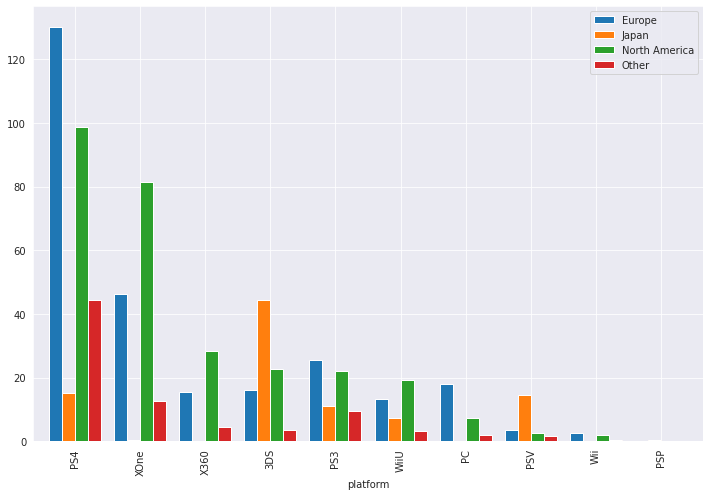

In [258]:
(
    data
        .pivot_table(index="platform", values=["na_sales", "eu_sales", "jp_sales", "other_sales"], aggfunc="sum").sort_values(by="na_sales", ascending=False)
        .plot(kind="bar", width=0.8, figsize=(12, 8))
        .legend(["Europe", "Japan", "North America", "Other"])
)
None

По полученным данным можно сделать следующие выводы:

* В Японии не используется XOne, но используется PS4. Возможно, туда пока нет поставок или данные о таких продажах отсутствуют. Также в Японии PS3 более популярна, чем X360. Скорее всего, это связано с тем, что компания Sony, создавшая PS, базируется в Японии, поэтому эти платформы там будут более популярны.
* 3DS и DS имеет максимальную популярность в Японии. Это платформы фирмы Nintendo, которая так же является Японской фирмой. По продажам игр на персональный компьютер данные в этой стране отсутствуют.
* Персональный компьютер больше всего популярен в Европе
* PS3 входит в топ-5 всех регионов
* В остальных регионах 5 самых популярных платформ совпадают с популярными платформами Северной Америки
* В Европе используют почти те же платформы, что и в Америке.

In [259]:
for country in region_columns:
    print(country.split('_')[0], ':',
          ' '.join(data.groupby("genre")[country].agg("sum").sort_values(ascending=False).head(5).index))

na : Shooter Action Sports Role-Playing Misc
eu : Action Shooter Sports Role-Playing Racing
jp : Role-Playing Action Fighting Misc Shooter
other : Action Shooter Sports Role-Playing Misc


Распределение популярных жанров в чем то схоже с популярными платформами.

Так, у Северной Америки и остальных регионов набор одинаков, и с набором Европы он отличается лишь в одном месте - в европе более популярны гонки. Япония сильно отличается от остальных регионов. Там лидируют ролевые игры и популярны жанры приключений.

Однако, во всех странах в топ 5 жанров входят Action, Sports и Misc. При этом жанр Action почти всегда на первом-втором месте.

Проверим влияние ESRB в различных регионах:

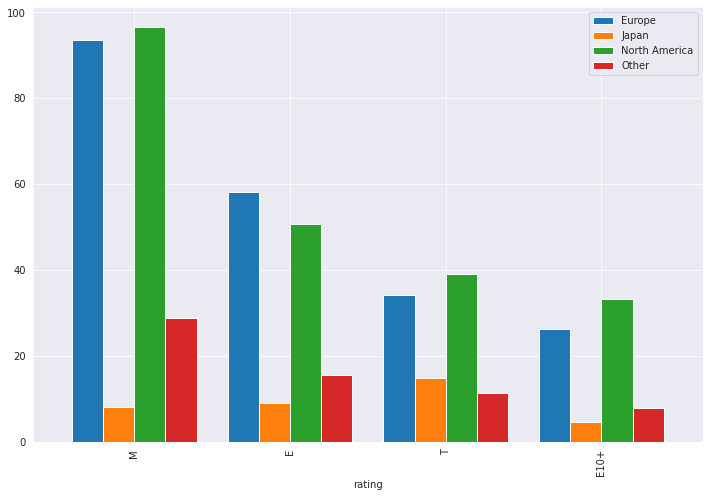

In [260]:
(
    data
    .pivot_table(index="rating", values=["na_sales", "eu_sales", "jp_sales", "other_sales"], aggfunc="sum").sort_values(by="na_sales", ascending=False)
    .plot(kind="bar", width=0.8, figsize=(12, 8))
    .legend(["Europe", "Japan", "North America", "Other"])
);

Из графика видно, в Японии больше всего продаж приходятся на рейтинг T. После него идут рейтинги E, M, E10+.

В Северной Америке и остальных регионах игры тем популярнее, чем ниже возраст целевой аудитории. Так, у E гораздо больше продаж, чем у M.

Однако, рейтинг E10+ не попадает под эту закономерность и показывает наименьшие продажи во всех регионах. Возможно, это связано с тем, что E10+ - промежуточный вариант между E и T, что сильно сужает целевую аудиторию.

Европа в целом похожа на Северную Америку и остальные регионы. Однако, здесь рейтинг M немного популярнее рейтинга T.

Можно сделать вывод, что для продажи в Японии лучше всего подойдут игры с рейтингом T и E, а для продажи в остальных странах - E и M.

Игры с рейтингом E10+ показывают наименьшую популярность, их стоит закупать лишь при сильной популярности.

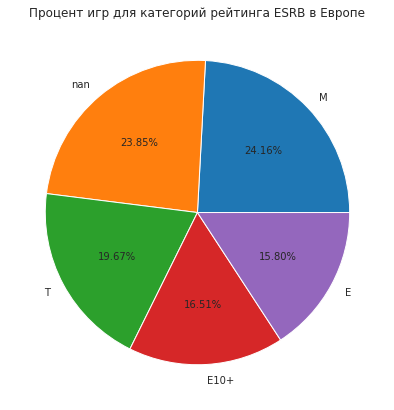

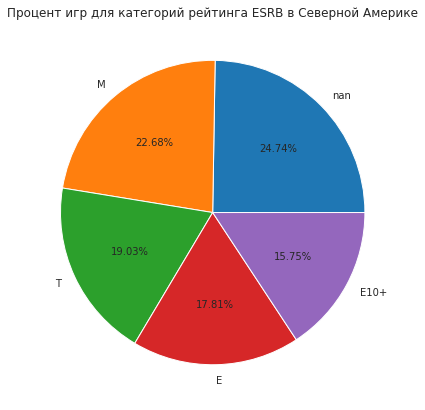

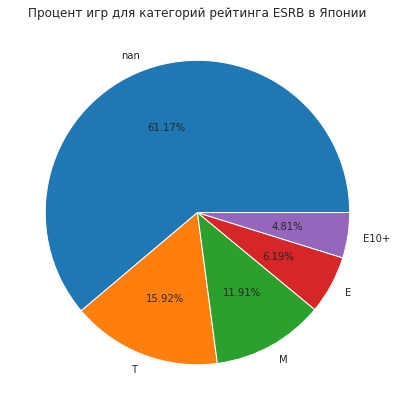

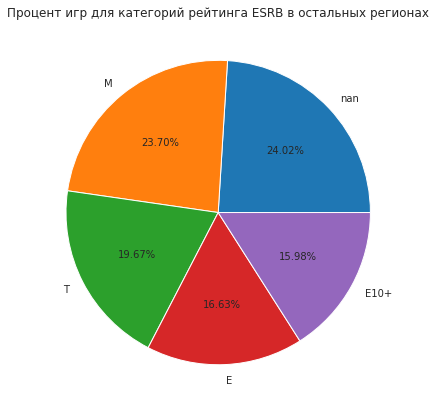

In [261]:
region_names = ["Европе", "Северной Америке", "Японии", "остальных регионах"]

for i in range(len(region_columns)):
    ax = (
            data[data[region_columns[i]] > 0]['rating'].value_counts(dropna=False)
                .plot(kind="pie", autopct='%1.2f%%', figsize=(7, 7))
         )
    ax.set_title(f"Процент игр для категорий рейтинга ESRB в {region_names[i]}")
    ax.set_ylabel("")
    plt.show()
None

Из графиков видно, в Японии более 60 % игр не имеют рейтинга ESRB. Это означает, что для данной страны будет некорректно анализировать то, игры с каким рейтингом ESRB подойдут в ней для продажи лучше всего. 

В остальных регионах процент игр без рейтинга не превышает 25%, что позволяет сделать некоторые выводы о продажах игр с определенным рейтингом.

В Северной Америке и остальных регионах игры с рейтингами M и E показывают самые хорошие уровни продаж. При этом рейтинг M значительно привосходит Е по продажам. Это может быть частично связано с тем, что за этими рейтингами стоят две наиболее широкие аудитории. 

Рейтинг E10+ показывает наименьшие продажи во всех регионах. Возможно, это связано с тем, что E10+ - промежуточный вариант между E и T, что сильно сужает целевую аудиторию.

В итоге, для продаж в этих странах хорошо подойдут игры с рейтингами M и E.

Игры с рейтингом E10+ показывают наименьшую популярность, их стоит закупать лишь при сильной популярности.


### Проверка гипотез, связанных со средними пользовательскими рейтингами

Проверим две гипотезы о рейтингах игр

Обе гипотезы сводятся к тому, что нам нужно сравнить средние двух генеральных совокупностей между собой по взятым из них выборкам. Так же эти две генеральные совокупности независимы относительно друг друга. Поэтому, будем использовать метод `scipy.stats.ttest_ind`, а уровень значимости возьмем равным 0.01.

При этом у двух выборок скорее всего отличается размер и дисперсия, поэтому параметр `equal_var` поставим `False`

Гипотеза 1: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;

```
H_0: Пользовательские рейтинги (user_score) для платформ Xbox One = Пользовательские рейтинги (user_score) для платформ PC`
H_1: Пользовательские рейтинги (user_score) для платформ Xbox One ≠ Пользовательские рейтинги (user_score) для платформ PC`
```


In [262]:
xbox = data[data['platform'] == 'XOne']['user_score'].dropna()
pc = data[data['platform'] == 'PC']['user_score'].dropna()
alpha = 0.01

_, pvalue = st.ttest_ind(xbox, pc, equal_var=False)

print(f'P-значение равно {pvalue:.5f}')

if pvalue < alpha:
    print("Нулевую гипотезу стоит отвергнуть")
else:
    print("Не получилось отвергнуть нулевую гипотезу")


P-значение равно 0.11601
Не получилось отвергнуть нулевую гипотезу


Таким образом, нельзя утверждать, что средние пользовательские рейтинги платформ Xbox One и PC значимо различаются.


Гипотеза 2: Средние пользовательские рейтинги жанров Action и Sports разные;


```
H_0: Пользовательские рейтинги (user_score) жанров Action = Пользовательские рейтинги (user_score) жанров Sports`
H_1: Пользовательские рейтинги (user_score) жанров Action ≠ Пользовательские рейтинги (user_score) жанров Sports`
```



In [263]:
action = data[data['genre'] == 'Action']['user_score'].dropna()
sports = data[data['genre'] == 'Sports']['user_score'].dropna()
alpha = 0.01

_, pvalue = st.ttest_ind(action, sports, equal_var=False)

print(f'P-значение равно {pvalue:.20f}')

if pvalue < alpha:
    print("Нулевую гипотезу стоит отвергнуть")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

P-значение равно 0.00000000000001182555
Нулевую гипотезу стоит отвергнуть


В данном случае уровень значимости значительно меньше. Поэтому нельзя утверждать, что средние пользовательские рейтинги жанров Action и Sports совпадают. Что еще раз подтверждает, что различные жанры воспринимаются пользователями по-разному и некоторые могут представлять больший интерес чем другие.

То есть мы отвергаем нулевую гипотезу, но исследовательская гипотеза принимается.

### Общий вывод

В ходе работы был исследован набор данных, описывающий отзывы и продажи различных видеоигр.

Был проведен исследовательский анализ данных, во время которого были найдены полезные для планирования следующей кампании закономерности. Были определены потенциально прибыльные платформы: XOne, PS4 и PC. Также было определено, что все эти платформы на протяжении долго времени являются лидерами рынка и занимают надежные позиции. Следующие платформы на данные момент теряют релевантность: 3DS, PS3, PSP, PSV, Wii, WiiU, X360. Так же для каждой платформы были проанализированы глобальные продажи и продажи по регионам. Новая версия Xbox (XOne) показывает самые высокие продажи, а конкурирующая ей платформа PS4 так же держится в топ 3. Было установлено, что между количеством продаж игры и её оценками критиками существует средне-слабая корреляция. Самым прибыльным жанром на актуальный период является Shooter, его продажи значительно превосходят остальные. Следующий по продажам, но менее распространенный жанр - Sports. Так же были составлены портреты игроков в различных регионах. И было установлено, что лучшие рейтинги игр для продаж в Европе и Северной Америке - "M" и "E".

Так же с помощью t-критерия Стьюдента были проверены две гипотезы. В результате нельзя утверждать, что средние пользовательские рейтинги платформ Xbox One и PC значимо различаются, а средние пользовательские рейтинги жанров Action и Sports совпадают.